In [1]:
# from split_data.py
import argparse
import csv
import os

import numpy as np
from PIL import Image
from tqdm import tqdm


def save_csv(data, path, fieldnames=['image_path', 'gender', 'articleType', 'baseColour']):
    with open(path, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(dict(zip(fieldnames, row)))


def split_data():
    input_folder = "fashion-product-images"
    output_folder = "fashion-product-images"
    annotation = os.path.join(input_folder, 'styles.csv')

    # open annotation file
    all_data = []
    with open(annotation) as csv_file:
        # parse it as CSV
        reader = csv.DictReader(csv_file)
        # tqdm shows pretty progress bar
        # each row in the CSV file corresponds to the image
        for row in tqdm(reader, total=reader.line_num):
            # we need image ID to build the path to the image file
            img_id = row['id']
            # we're going to use only 3 attributes
            gender = row['gender']
            articleType = row['articleType']
            baseColour = row['baseColour']
            img_name = os.path.join(input_folder, 'images', str(img_id) + '.jpg')
            # check if file is in place
            if os.path.exists(img_name):
                # check if the image has 80*60 pixels with 3 channels
                img = Image.open(img_name)
                if img.size == (60, 80) and img.mode == "RGB":
                    all_data.append([img_name, gender, articleType, baseColour])

    # set the seed of the random numbers generator, so we can reproduce the results later
    np.random.seed(42)
    # construct a Numpy array from the list
    all_data = np.asarray(all_data)
    # Take 40000 samples in random order
    inds = np.random.choice(40000, 40000, replace=False)
    # split the data into train/val and save them as csv files
    save_csv(all_data[inds][:32000], os.path.join(output_folder, 'train.csv'))
    save_csv(all_data[inds][32000:40000], os.path.join(output_folder, 'val.csv'))

split_data()

44446it [00:14, 3035.96it/s]


In [2]:
# from dataset.py

import csv

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class AttributesDataset():
    def __init__(self, annotation_path):
        color_labels = []
        gender_labels = []
        article_labels = []

        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                color_labels.append(row['baseColour'])
                gender_labels.append(row['gender'])
                article_labels.append(row['articleType'])

        self.color_labels = np.unique(color_labels)
        self.gender_labels = np.unique(gender_labels)
        self.article_labels = np.unique(article_labels)

        self.num_colors = len(self.color_labels)
        self.num_genders = len(self.gender_labels)
        self.num_articles = len(self.article_labels)

        self.color_id_to_name = dict(zip(range(len(self.color_labels)), self.color_labels))
        self.color_name_to_id = dict(zip(self.color_labels, range(len(self.color_labels))))

        self.gender_id_to_name = dict(zip(range(len(self.gender_labels)), self.gender_labels))
        self.gender_name_to_id = dict(zip(self.gender_labels, range(len(self.gender_labels))))

        self.article_id_to_name = dict(zip(range(len(self.article_labels)), self.article_labels))
        self.article_name_to_id = dict(zip(self.article_labels, range(len(self.article_labels))))


class FashionDataset(Dataset):
    def __init__(self, annotation_path, attributes, transform=None):
        super().__init__()

        self.transform = transform
        self.attr = attributes

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data = []
        self.color_labels = []
        self.gender_labels = []
        self.article_labels = []

        # read the annotations from the CSV file
        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row['image_path'])
                self.color_labels.append(self.attr.color_name_to_id[row['baseColour']])
                self.gender_labels.append(self.attr.gender_name_to_id[row['gender']])
                self.article_labels.append(self.attr.article_name_to_id[row['articleType']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data[idx]

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and all the associated labels
        dict_data = {
            'img': img,
            'labels': {
                'color_labels': self.color_labels[idx],
                'gender_labels': self.gender_labels[idx],
                'article_labels': self.article_labels[idx]
            }
        }
        return dict_data

In [3]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class MultiOutputModel(nn.Module):
    def __init__(self, n_color_classes, n_gender_classes, n_article_classes):
        super().__init__()
        self.base_model = models.mobilenet_v2().features  # take the model without classifier
        last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_color_classes)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_gender_classes)
        )
        self.article = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_article_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'color': self.color(x),
            'gender': self.gender(x),
            'article': self.article(x)
        }

    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['color'], ground_truth['color_labels'])
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender_labels'])
        article_loss = F.cross_entropy(net_output['article'], ground_truth['article_labels'])
        loss = color_loss + gender_loss + article_loss
        return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}

In [4]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    _, predicted_color = output['color'].cpu().max(1)
    gt_color = target['color_labels'].cpu()

    _, predicted_gender = output['gender'].cpu().max(1)
    gt_gender = target['gender_labels'].cpu()

    _, predicted_article = output['article'].cpu().max(1)
    gt_article = target['article_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_color = accuracy_score(y_true=gt_color.numpy(), y_pred=predicted_color.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_article = accuracy_score(y_true=gt_article.numpy(), y_pred=predicted_article.numpy())

    return accuracy_color, accuracy_gender, accuracy_article

In [5]:
import matplotlib.pyplot as plt

def visualize_gt_data(dataset, attributes):
    imgs = []
    gt_labels = []

    n_cols = 5
    n_rows = 3

    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for img_idx in range(n_cols * n_rows):
        sample = dataset[img_idx]
        img = sample['img']
        labels = sample['labels']
        gt_color = attributes.color_id_to_name[labels['color_labels']]
        gt_gender = attributes.gender_id_to_name[labels['gender_labels']]
        gt_article = attributes.article_id_to_name[labels['article_labels']]
        
        imgs.append(img)
        gt_labels.append("{}\n{}\n{}".format(gt_gender, gt_article, gt_color))

    title = "Ground truth labels"

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, gt_labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # restore original transforms
    dataset.transform = transforms

In [6]:
def checkpoint_load(model, name):
    print('Restoring checkpoint: {}'.format(name))
    model.load_state_dict(torch.load(name, map_location='cpu'))
    epoch = int(os.path.splitext(os.path.basename(name))[0].split('-')[1])
    return epoch


def net_output_to_predictions(output):
    _, predicted_colors = output['color'].cpu().max(1)
    _, predicted_genders = output['gender'].cpu().max(1)
    _, predicted_articles = output['article'].cpu().max(1)

    return predicted_colors.numpy().tolist(), predicted_genders.numpy().tolist(), predicted_articles.numpy().tolist()


def validate(model, dataloader, device, logger=None, epoch=None, checkpoint=None):
    if checkpoint is not None:
        checkpoint_load(model, checkpoint)

    model.eval()
    color_predictions = []
    gender_predictions = []
    article_predictions = []
    with torch.no_grad():
        avg_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in dataloader:
            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            val_train, val_train_losses = model.get_loss(output, target_labels)
            avg_loss += val_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            (batch_color_predictions,
             batch_gender_predictions,
             batch_article_predictions) = net_output_to_predictions(output)

            color_predictions.extend(batch_color_predictions)
            gender_predictions.extend(batch_gender_predictions)
            article_predictions.extend(batch_article_predictions)

    n_samples = len(dataloader)
    avg_loss /= n_samples
    accuracy_color /= n_samples
    accuracy_gender /= n_samples
    accuracy_article /= n_samples
    print('-' * 72)
    print("Validation  loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}\n".format(
        avg_loss, accuracy_color, accuracy_gender, accuracy_article))

    if logger is not None and epoch is not None:
        logger.add_scalar("val_loss", avg_loss, epoch)
        logger.add_scalar("val_accuracy/color", accuracy_color, epoch)
        logger.add_scalar("val_accuracy/gender", accuracy_gender, epoch)
        logger.add_scalar("val_accuracy/article", accuracy_article, epoch)
    model.train()

    return color_predictions, gender_predictions, article_predictions

In [7]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    


def train(start_epoch=1, N_epochs=50, batch_size=16, num_workers=8):
    attributes_file = 'fashion-product-images/styles.csv'
    device = torch.device('cuda')

    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # specify image transforms for augmentation during training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                shear=None, resample=False, fillcolor=(255, 255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = FashionDataset('fashion-product-images/train.csv', attributes, train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = FashionDataset('fashion-product-images/val.csv', attributes, val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = MultiOutputModel(n_color_classes=attributes.num_colors,
                             n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles)\
                            .to(device)

    optimizer = torch.optim.Adam(model.parameters())

    logdir = os.path.join('logs', get_cur_time())
    print(logdir)
    savedir = os.path.join('checkpoints', get_cur_time())
    print(savedir)
    os.makedirs(logdir, exist_ok=False)
    os.makedirs(savedir, exist_ok=False)
    logger = SummaryWriter(logdir)

    n_train_samples = len(train_dataloader)

    
    visualize_gt_data(val_dataset, attributes)
    print("\nAll gender labels:\n", attributes.gender_labels)
    print("\nAll color labels:\n", attributes.color_labels)
    print("\nAll article labels:\n", attributes.article_labels)

    print("Starting training ...")

    checkpoint_path = None
    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d}, loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_color / n_train_samples,
            accuracy_gender / n_train_samples,
            accuracy_article / n_train_samples))

        logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 25 == 0:
            checkpoint_path = checkpoint_save(model, savedir, epoch)

        if epoch % 5 == 0:
            validate(model, val_dataloader, device, logger, epoch)
            
    checkpoint_path = checkpoint_save(model, savedir, epoch - 1)

    return checkpoint_path

logs\2020-11-23_12-12
checkpoints\2020-11-23_12-12


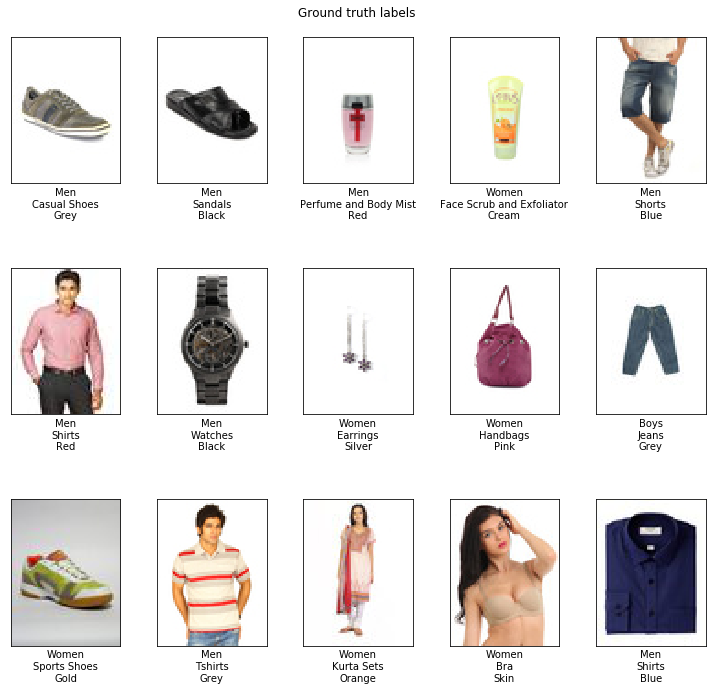


All gender labels:
 ['Boys' 'Girls' 'Men' 'Unisex' 'Women']

All color labels:
 ['Beige' 'Black' 'Blue' 'Bronze' 'Brown' 'Burgundy' 'Charcoal'
 'Coffee Brown' 'Copper' 'Cream' 'Fluorescent Green' 'Gold' 'Green' 'Grey'
 'Grey Melange' 'Khaki' 'Lavender' 'Lime Green' 'Magenta' 'Maroon' 'Mauve'
 'Metallic' 'Multi' 'Mushroom Brown' 'Mustard' 'NA' 'Navy Blue' 'Nude'
 'Off White' 'Olive' 'Orange' 'Peach' 'Pink' 'Purple' 'Red' 'Rose' 'Rust'
 'Sea Green' 'Silver' 'Skin' 'Steel' 'Tan' 'Taupe' 'Teal' 'Turquoise Blue'
 'White' 'Yellow']

All article labels:
 ['Accessory Gift Set' 'Baby Dolls' 'Backpacks' 'Bangle' 'Basketballs'
 'Bath Robe' 'Beauty Accessory' 'Belts' 'Blazers' 'Body Lotion'
 'Body Wash and Scrub' 'Booties' 'Boxers' 'Bra' 'Bracelet' 'Briefs'
 'Camisoles' 'Capris' 'Caps' 'Casual Shoes' 'Churidar' 'Clothing Set'
 'Clutches' 'Compact' 'Concealer' 'Cufflinks' 'Cushion Covers' 'Deodorant'
 'Dresses' 'Duffel Bag' 'Dupatta' 'Earrings' 'Eye Cream' 'Eyeshadow'
 'Face Moisturisers' 'Face Sc

BrokenPipeError: [Errno 32] Broken pipe

In [8]:
last_checkpoint_path = train()